In [2]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [79]:
# Import libraries
import os
import numpy as np

from plantcv import plantcv as pcv 
from read_dataset import read_dataset
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

# IMPORTANT: Create a directory to save the output labels and set the path in self.outdir

class options:
    def __init__(self):        
        self.image = ""
        self.debug = "plot"
        self.writeimg = False
        self.outdir = os.path.join(os.getcwd(), "outputs")
        self.rgb_outdir = os.path.join(self.outdir, "images_cropped_rgb")
        self.bw_outdir = os.path.join(self.outdir, "images_cropped_bw")
        self.shapes_json = os.path.join(self.outdir, "segmentation.json")
        self.shapes_csv = os.path.join(self.outdir, "segmentation.csv")
        self.individual_shapes_folder = os.path.join(self.outdir, "shape_data")
        self.masks_outdir = os.path.join(self.outdir, "masks_compressed")

In [5]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# set the output directory to the global parameter
pcv.params.debug_outdir = args.masks_outdir

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

In [72]:
# Paths to the directories containing the rgb images and the binary masks
#images_directory = '/mnt/stor/ceph/csb/marsfarm/projects/marsfarm_image_analysis/inputs/MV1-0041_6.2.23-6.20.23(Peas)/'
#images_directory = '/mnt/stor/ceph/csb/marsfarm/projects/marsfarm_image_analysis/inputs/MV1-0039_7.11.23-8.11.23(Tomato)/'
images_directory = '/mnt/stor/ceph/csb/marsfarm/projects/marsfarm_image_analysis/inputs/MV1-0043_6.1.23-6.16.23(Purple Basil)'
masks_directory =  '/mnt/stor/ceph/csb/marsfarm/projects/marsfarm_image_analysis/inputs/masks/MV1-0039_7.11.23-8.11.23(Tomato)/'

# Create the lists of paths to the images and masks
# The read_dataset function is included in this repository, infuture versions it will 
# be included in the PlantCV package
images_paths_sort = read_dataset(source_path=images_directory, sort=True)
masks_paths_sort = read_dataset(source_path=masks_directory, sort=True)

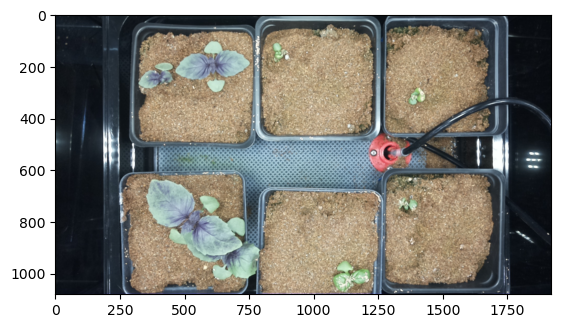

In [73]:
# Read the first image in the datased to be used as reference for the ROIs
i = 3
img0_path = images_paths_sort[i]
img0, _, _ = pcv.readimage(filename=img0_path)

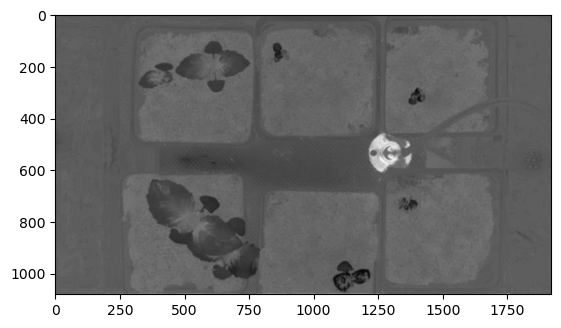

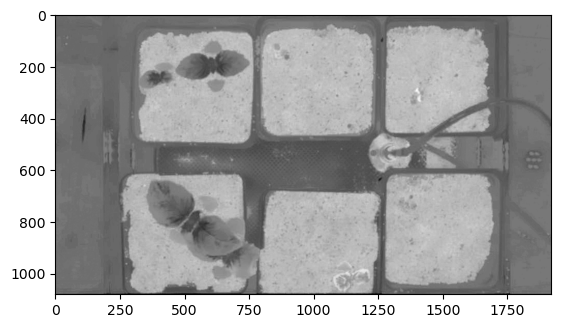

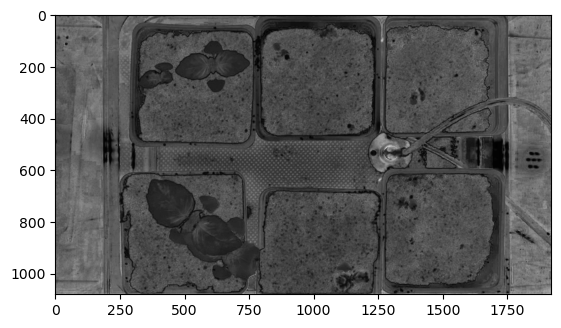

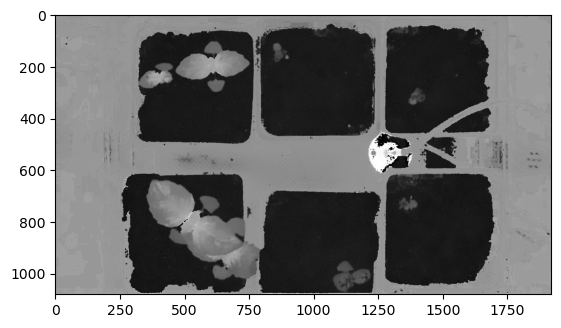

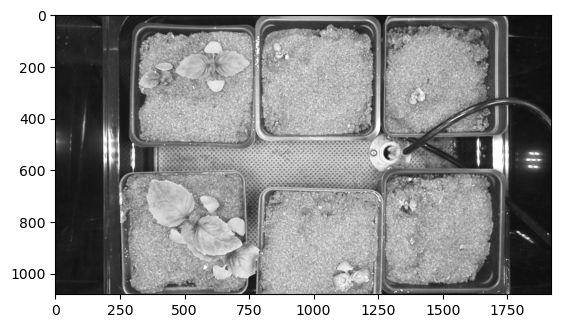

In [74]:
#peas seems to work best with a and s
#tomato seems to work best with a combination of b and h
#Basil seems to do well with a or b

a = pcv.rgb2gray_lab(rgb_img=img0, channel='a')
b = pcv.rgb2gray_lab(rgb_img=img0, channel='b')
s = pcv.rgb2gray_hsv(rgb_img=img0, channel='s')
h = pcv.rgb2gray_hsv(rgb_img=img0, channel='h')
v = pcv.rgb2gray_hsv(rgb_img=img0, channel='v')

In [75]:
his_figureA, hist_dataA = pcv.visualize.histogram(a, hist_data=True)
his_figureB, hist_dataB = pcv.visualize.histogram(b, hist_data=True)
his_figureH, hist_dataH = pcv.visualize.histogram(h, hist_data=True)
his_figureS, hist_dataS = pcv.visualize.histogram(s, hist_data=True)
his_figureV, hist_dataV = pcv.visualize.histogram(v, hist_data=True)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

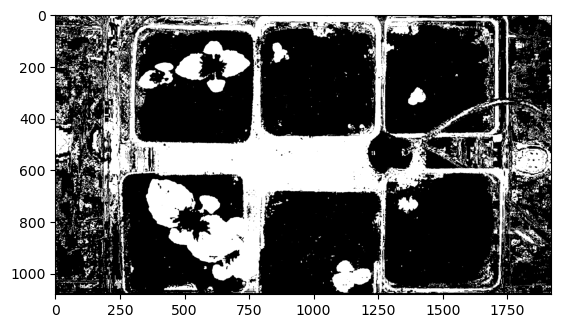

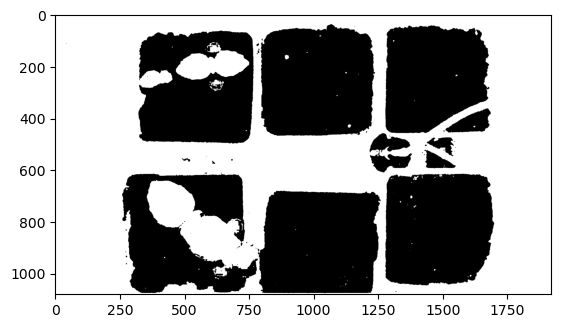

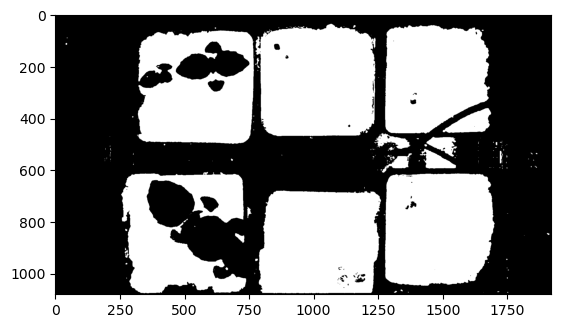

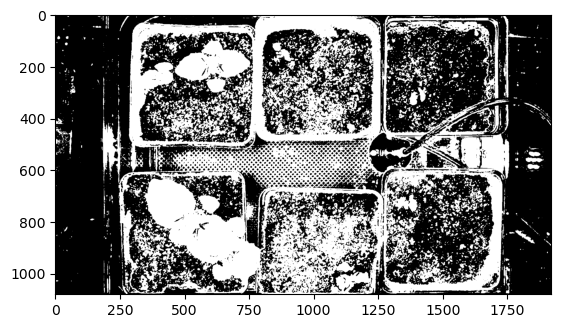

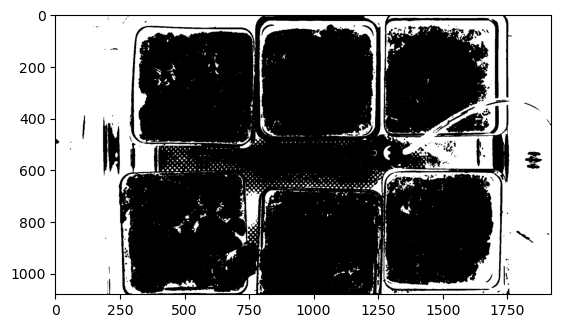

In [76]:
thresholded_imageA = pcv.threshold.otsu(gray_img=a, object_type='dark')
thresholded_imageB = pcv.threshold.otsu(gray_img=b, object_type='dark')
thresholded_imageH = pcv.threshold.otsu(gray_img=h, object_type='dark')
thresholded_imageS = pcv.threshold.otsu(gray_img=s, object_type='dark')
thresholded_imageV = pcv.threshold.otsu(gray_img=v, object_type='dark')

[  0 255]


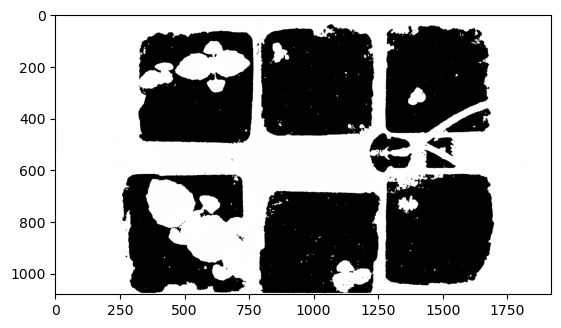

In [90]:
combined_peas = (thresholded_imageA + thresholded_imageB)
print(np.unique(thresholded_imageA))
imgplot = plt.imshow(combined_peas, cmap='gray')

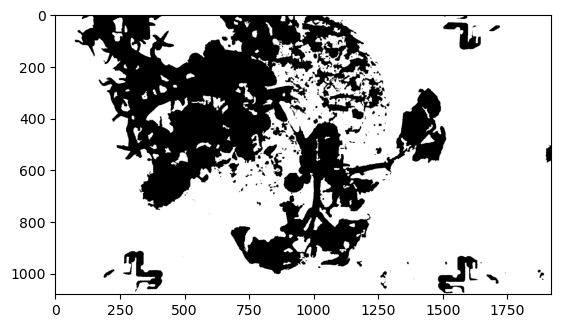

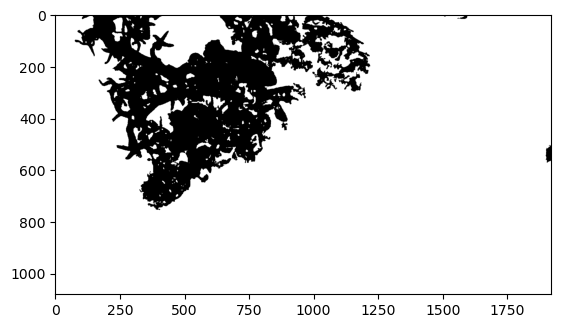

In [71]:
a_fill = pcv.fill(bin_img=thresholded_imageB, size=100)
a_fill = pcv.fill_holes(thresholded_imageB)

In [ ]:
combined = 

In [10]:
a_fill[:, :150] = 0

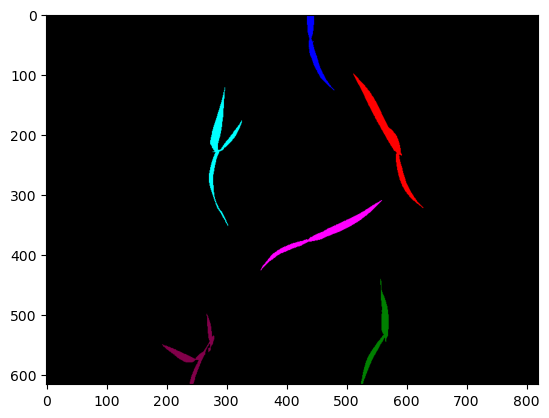

In [11]:
#Label the objects in your region of interest and number them
#Each object should be a different color. If your objects are the same color and/or are touching, go back to your mask so that they are separate or it will treat them as a single object

#    mask            = the clean mask you made above after making your ROI

labeled_objects, n_obj = pcv.create_labels(mask=a_fill)

# This example has one color per leaf, so this would be good enough to do per-replicate trait extraction. 

In [12]:
print(np.unique(labeled_objects))

[0 1 2 3 4 5 6]


In [13]:
print(n_obj)

6


I'm using a rudimentary mean approximation to guess where I should put the rois at

In [14]:
import sys, os
#import cv2
def get_roi_centers_and_individual_images(labeled_mask: np.ndarray, num_plants: int):

    #debugging stuff
    #print("image shape:")
    #print(img.shape)
    #print("mask shape:")
    #print(labeled_mask.shape)
    #print(img[:, 0, 0].shape)
    #print(img[0, :, 0].shape)
    #print(img[0, 0, :].shape)

    center_points = []
    for number in range(1, num_plants+1):
        # Create a mask for the current number
        mask = labeled_mask == number
        
        # Find indices where the mask is True
        cols, rows = np.nonzero(mask)
        
        if rows.size > 0 and cols.size > 0:
            # Calculate bounds
            #rows = y axis, columns = x axis, depth = z axis
            min_row, max_row = np.min(rows), np.max(rows)
            min_col, max_col = np.min(cols), np.max(cols)

            middle_row = (min_row + max_row) // 2
            middle_col = (min_col + max_col) // 2

            center_points.append((middle_row, middle_col))

            #get rgb images clipped to bounds of labels, export to image file
            chopped_image_rgb = img0[min_col:max_col+1, min_row:max_row+1, :]
            output_path_rgb = os.path.join(args.rgb_outdir, f"plant_rgb_{number}.png")
            pcv.print_image(chopped_image_rgb, output_path_rgb)

            #get black and white image bounds,  export to image file
            chopped_image_bw = labeled_mask[min_col:max_col+1, min_row:max_row+1]
            chopped_image_bw = chopped_image_bw.astype(bool).astype('uint8') * 255
            p = Image.fromarray(chopped_image_bw)
            output_path_bw = os.path.join(args.bw_outdir, f"plant_bw_{number}.png")
            p.save(output_path_bw)
                                                                    
            
        else:
            print(f"no indices for {number}")
            continue
    return center_points

centers = get_roi_centers_and_individual_images(labeled_objects, n_obj)

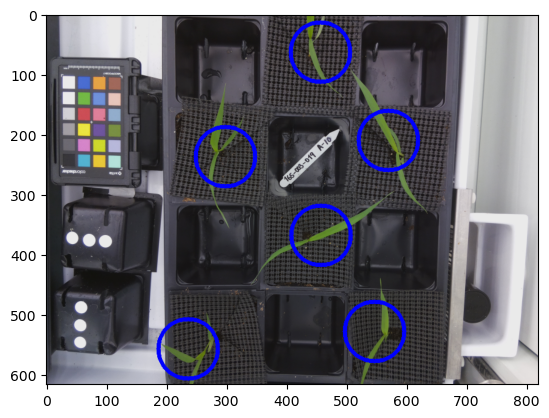

In [15]:
rois = pcv.roi.multi(img=img0, coord=centers, radius=50)

In [16]:
len(rois.contours)

6

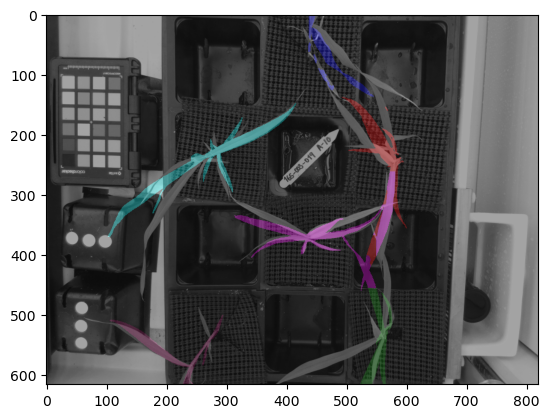

In [19]:
# Run segment image series 
out = pcv.segment_image_series(images_paths_sort, masks_paths_sort, rois=rois.contours , save_labels=True, ksize=3)

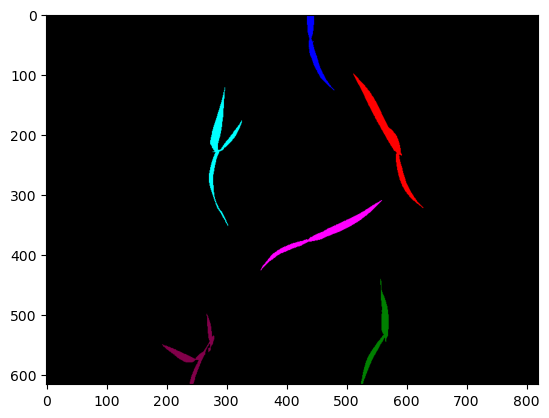

In [20]:
#it probably isn't necessary to recrate the mask and the labels, but I'm doing it to show how it is done.
lbl_mask, n_lbls = pcv.create_labels(mask=a_fill, rois=rois, roi_type="partial")

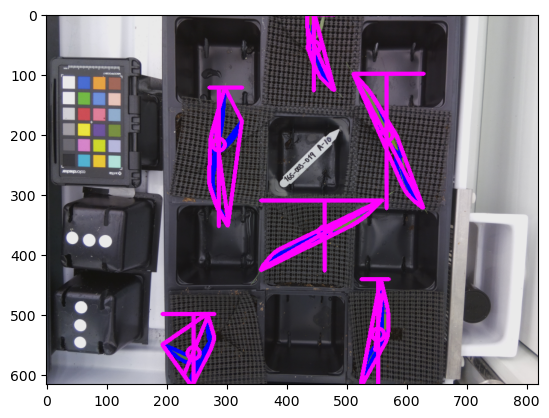

In [29]:
# Analyze the shape of each plant 
shape_img = pcv.analyze.size(img=img0, labeled_mask=lbl_mask, n_labels=n_lbls, label="plant")

In [53]:
#output a csv file with shape data for all plants in the image
pcv.outputs.save_results(filename=args.shapes_csv, outformat="csv")

pcv.outputs.save_results(filename=args.shapes_json, outformat="json")

In [60]:
keys = list(pcv.outputs.observations.keys())

for key in keys:
    df = pd.DataFrame.from_dict(pcv.outputs.observations[key], orient='index')
    outputs_path = os.path.join(args.individual_shapes_folder, key+".csv")
    df.to_csv(outputs_path)